In [1]:
# Here is a classical max cut QAOA inspired from:
#  https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
#  https://qiskit.org/textbook/ch-applications/qaoa.html
#  https://lucaman99.github.io/new_blog/2020/mar16.html

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

In [103]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

Number of nodes :  5
Nodes colors: 
 ['r', 'r', 'r', 'r', 'r']
Weight matrix: 
 [[0. 6. 0. 0. 0.]
 [6. 0. 1. 6. 6.]
 [0. 1. 0. 1. 0.]
 [0. 6. 1. 0. 0.]
 [0. 6. 0. 0. 0.]]
#######################################################################################


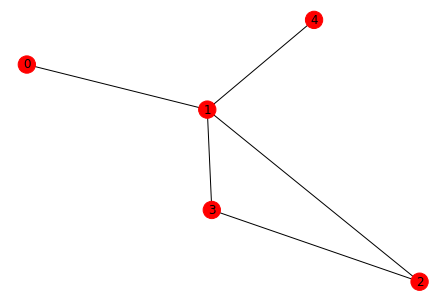

In [51]:
# First let's build some usefull function to creat Graphs and color them:

class Graph:
    def __init__(self,nr_nodes, edge_list):
        self.edge_list=edge_list
        self.G=nr_nodes
        self.colors=['r' for i in range(nr_nodes)]
        self.G=self.Graph() 
        self.W=self.WeightMatrix()

        
        
    def Graph(self):
        G=nx.Graph()
        G.add_nodes_from(np.arange(0,self.nr_nodes,1))
        G.add_weighted_edges_from(self.edge_list)
        return G
    
    def  WeightMatrix(self):
        W=np.zeros([self.nr_nodes,self.nr_nodes])
        for i in range (self.nr_nodes):
            for j in range(self.nr_nodes):
                temp=self.G.get_edge_data(i,j,default=0)
                if temp!=0:
                    W[i,j]=temp['weight']
        return W
        
        
    
elist=[(2,1,1.0),(1,0,6.0),(2,3,1.0),(1,3,6.0),(1,4,6.0)]
G1=Graph(5,elist)

print("Number of nodes : ",G1.nr_nodes)
print("Nodes colors: \n",G1.colors)
print("Weight matrix: \n",G1.W)
print("#######################################################################################")
nx.draw(G1.G,node_color=G1.colors,with_labels=True)

In [59]:
#brut force  for verification  :
def brut_MaxCut(Gr):
    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**Gr.nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(Gr.nr_nodes)))]
        cost=0
        for i in range(Gr.nr_nodes):
            for j in range(Gr.nr_nodes):
                cost=cost+Gr.W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            max_str.append(str(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            max_str.append(str(x))
 
            
    return  max_str, best_cost_brute
            
        
max_str, best_cost= brut_MaxCut(G1)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=19.0): 
 
[0, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 0, 1, 1]
[1, 0, 1, 1, 1]


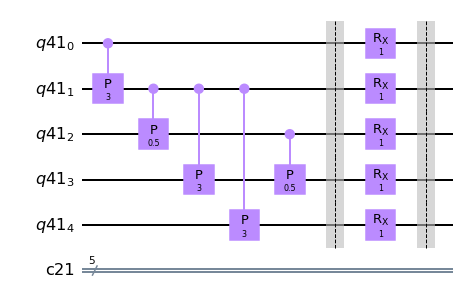

In [112]:
Gr=G1

nrq=G1.nr_nodes

qr=QuantumRegister(nrq)
cr=ClassicalRegister(nrq)
qc=QuantumCircuit(qr,cr)



def HC_01(qc,qr,gamma,W):
    
    W=W*gamma
    for i in range(len(qr)):
        for j in range(i+1,len(qr)):
            if W[i][j]!=0:
                qc.cp(W[i,j],qr[i],qr[j])
    qc.barrier()

def HB_01(qc,qr,beta):
    
    for i in range(len(qr)):
        qc.rx(2*beta,qr[i])
    qc.barrier()

HC_01(qc,qr,0.5,G1.W)
HB_01(qc,qr,0.5)

qc.draw('mpl')

In [113]:
def Init_H(qc,qr,list=[]):
    for i in range(int(len(qr))):
        qc.h(qr[i])
    qc.barrier()

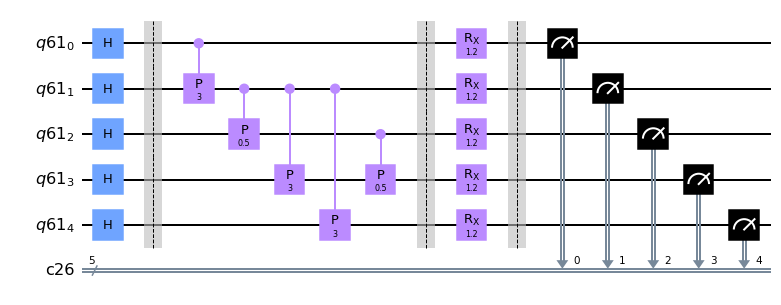

In [144]:
def QAOA_circ_01(Gr,params,l=1):
    
    qr=QuantumRegister(nrq)
    cr=ClassicalRegister(nrq)
    qc=QuantumCircuit(qr,cr)
    
    Init_H(qc,qr)
    for i in range(l):
        HC_01(qc,qr,params[i*2],Gr.W)
        HB_01(qc,qr,params[i*2+1])
    
    for i in range(nrq):
        qc.measure(qr[i],cr[i])
        
    return qc

QAOA_circ=QAOA_circ_01(G1,[0.5,0.6],l=1)
QAOA_circ.draw('mpl')  

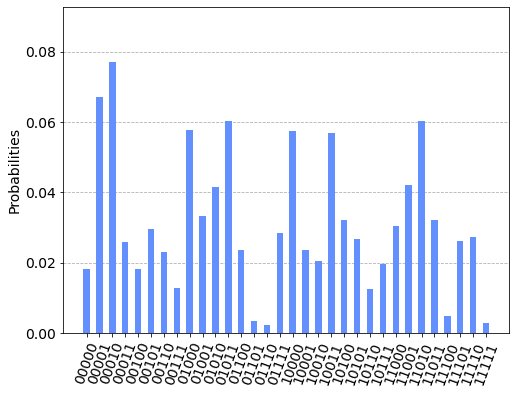

In [153]:
backend=Aer.get_backend("qasm_simulator")
shots=5000

simulate=execute(QAOA_circ, backend=backend, shots=shots)
results=simulate.result()
counts=results.get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = False)

In [154]:
def expected_01(counts,Gr):
    cost=0
    for x in counts:
        for i in range (Gr.nr_nodes):
            for j in range(i+1,Gr.nr_nodes):
                if x[i]!=x[j]:
                    cost=cost-Gr.W[i][j]*counts[x]
    cost=cost/shots
    return cost

cost=expected_01(counts,G1)
print(cost)

-9.9704


In [155]:
def QAOA_cost(Gr,params,l=1,
            backend=Aer.get_backend("qasm_simulator"),shots=500):
    
    qc=QAOA_circ_01(Gr,params,l=1)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    cost=expected_01(counts,Gr)
    return cost

cost=QAOA_cost(Gr,[0.5,0.7],l=1,
            backend=Aer.get_backend("qasm_simulator"),shots=500)
print(cost)

-0.9914
